# CTM MILP Model Running Environment (New Greentime Dateframe Format)

**NOTE:** When about to make a new run, please **duplicate** this notebook then add necessary graphs and things below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *

# Add more CTM models here as needed
from ctmmodels.ringbarrier import DTSimplexRingBarrier as NewModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* Default parameters used before:

{

    time_range = 30
    time_ticks = np.arange(0, time_range+1, 1)

    parameters = {
        'r_left': 1.0/3.0,
        'r_through': 1.0/3.0,
        'r_right': 1.0/3.0,
        'sat_flow_rate': 1800,
        'time_range': time_range,
        'time_step': 2,
        'g_min': 6,
        'g_max': 20
    }

}

* Saturation flow rate was set to 1800 vphpl, as this was the closest realistic value that matched the calculations from the parent paper.

* Traffic will be distributed evenly between the 4 lanes (left, through 1, through 2, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

# Varying parameters: demand, alpha, beta, gamma

In [17]:
def run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True):
    if new_model:
        model = NewModel(
            demand=demand,
            alpha=weights[0],
            beta=weights[1],
            gamma=weights[2],
            **parameters
        )
    else:
        model = OldModel(
            demand=demand,
            **parameters
        )

    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime, model

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [5]:
_approach = SOUTHBOUND

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path=_cell_path, title="Volume (Instantaneous and Cumulative)", headless=False, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path=_cell_path, title="Flow (Instantaneous and Cumulative)", headless=False, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title="Greentime graphs", headless=False, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

In [9]:
def plot_greentime_nophase(dfg):
    df_g_map = dfg.pivot(index='timestep', columns='cell', values='is_green')
    approaches = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

    _, axs = plt.subplots(4,3,figsize=(20,20), sharey=True)

    for i in range(4):
        for j in range(3):
             sns.lineplot(data=df_g_map[[approaches[i][j]]], ax=axs[i][j])

## Comparing greentime as a heatmap

In [10]:
def plot_greentime_map(dfg, title="Greentime maps", headless=False, filename='greentime.png', movements=True):
    fig, axs = plt.subplots(figsize=(18,8))

    dfg_matrix = dfg.T
    if movements:
        dfg_matrix = dfg_matrix.reindex(index=[
            (2,LEFT_TURN,EASTBOUND), (2,RIGHT_TURN,EASTBOUND), (2,THROUGH_TURN,EASTBOUND),
            (2,LEFT_TURN,NORTHBOUND), (2,RIGHT_TURN,NORTHBOUND), (2,THROUGH_TURN,NORTHBOUND),
            (2,LEFT_TURN,SOUTHBOUND), (2,RIGHT_TURN,SOUTHBOUND), (2,THROUGH_TURN,SOUTHBOUND),
            (2,LEFT_TURN,WESTBOUND), (2,RIGHT_TURN,WESTBOUND), (2,THROUGH_TURN,WESTBOUND),
        ])
    sns.heatmap(data=dfg_matrix)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [11]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [12]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [13]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 1. Checking correctness of formats

### New Model

In [18]:
demand = 600

dfx, dfy, dfg, _, obj_values, runtime, model = run_model(demand, weights=(0.4, 0.4, 0.2), new_model=True, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 3172 rows and 292 columns.
MIP Presolve modified 756 coefficients.
Aggregator did 142 substitutions.
Reduced MIP has 3488 rows, 1906 columns, and 11472 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.12 ticks)
Found incumbent of value 913.976488 after 0.03 sec. (23.44 ticks)
Probing fixed 0 vars, tightened 104 bounds.
Probing time = 0.00 sec. (0.55 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2796 rows, 1714 columns, and 9972 nonzeros.
Reduced MIP has 270 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.36 ticks)
Probing time = 0.00 sec. (1.18 ticks)
Tried aggregator 1 time.
MIP Presolve modified 8 coefficients.
Reduced MIP has 2796 rows, 1714 columns, and 9972 nonzeros.
Reduced MIP has 270 binaries, 0 g

In [19]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 75.1463489532

Delay: 1161.51898734

Throughput: 56.2784810127

Objective Value: -144.175169422


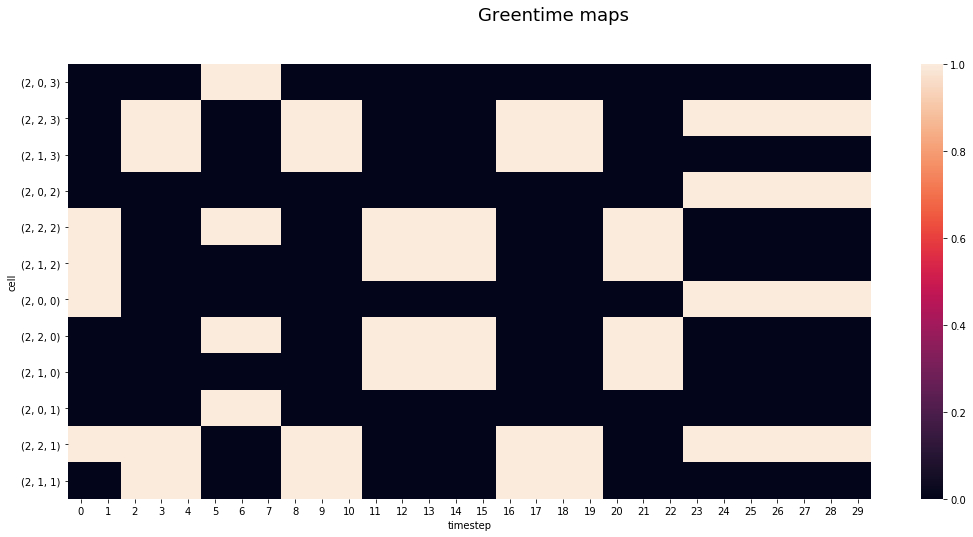

In [20]:
plot_greentime_map(dfg)

In [29]:
dfg_phases = model.return_phases()
dfg_phases = dfg_phases.pivot(index='timestep', columns='cell', values='is_green')
dfg_phases

cell,"(0, 0, 0)","(0, 0, 1)","(0, 1, 0)","(0, 1, 1)","(1, 0, 0)","(1, 0, 1)","(1, 1, 0)","(1, 1, 1)"
timestep,,,,,,,,
0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,1
2,0,1,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0
5,1,0,0,0,1,0,0,0
6,1,0,0,0,1,0,0,0
7,1,0,0,0,1,0,0,0
8,0,1,0,0,0,1,0,0


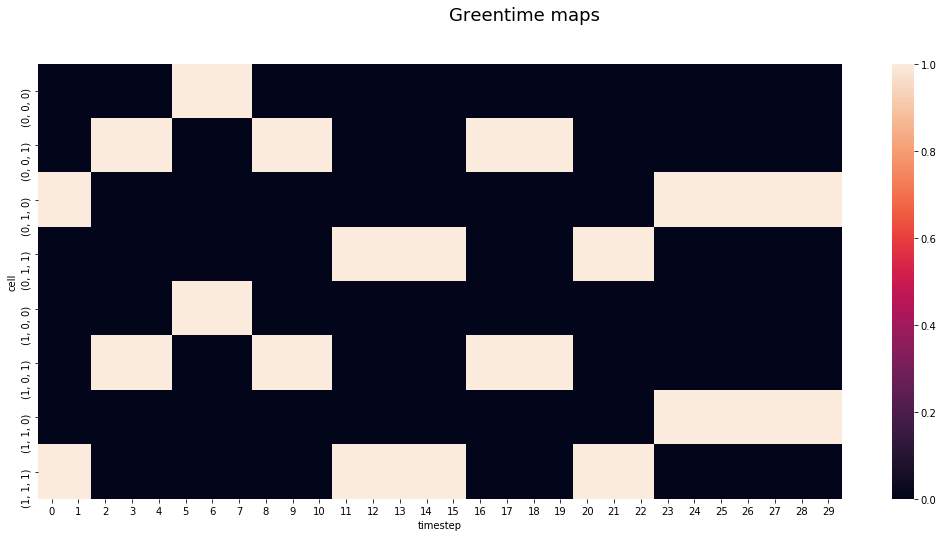

In [30]:
plot_greentime_map(dfg_phases, movements=False)

### Old Model, FRR = 1

In [33]:
demand = 600

dfx, dfy, dfg, _, obj_values, runtime, model = run_model(demand, new_model=False, log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 3 times.
MIP Presolve eliminated 4208 rows and 580 columns.
MIP Presolve modified 568 coefficients.
Aggregator did 770 substitutions.
Reduced MIP has 2372 rows, 1470 columns, and 7308 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (17.70 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1140 rows and 720 columns.
Reduced MIP has 1232 rows, 750 columns, and 3990 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.28 ticks)
Probing time = 0.00 sec. (0.09 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (25.77 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer 

In [34]:
print('''
Runtime: {}\n
Delay: {}\n
Throughput: {}\n
Objective Value: {}'''.format(runtime, *obj_values))


Runtime: 0.187783002853

Delay: 1216.55696203

Throughput: 66.835443038

Objective Value: 66.835443038


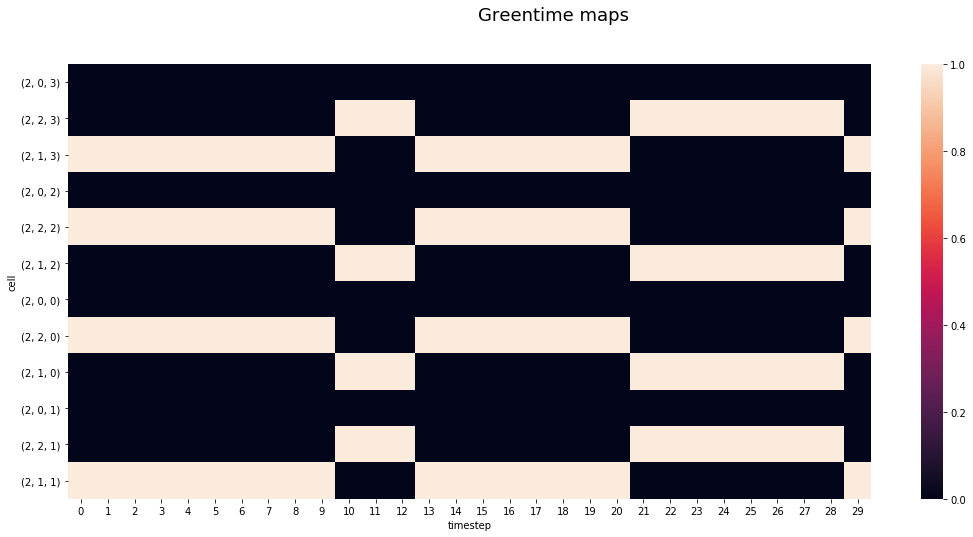

In [35]:
plot_greentime_map(dfg)